In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from copy import deepcopy

[[0.         0.         0.5        1.        ]
 [0.         0.         0.5        0.99607843]
 [0.         0.         0.5        0.99215686]
 ...
 [0.         0.         0.5        0.00784314]
 [0.         0.         0.5        0.00392157]
 [0.         0.         0.5        0.        ]]
[[0.5        0.         0.         1.        ]
 [0.5        0.         0.         0.99607843]
 [0.5        0.         0.         0.99215686]
 ...
 [0.5        0.         0.         0.00784314]
 [0.5        0.         0.         0.00392157]
 [0.5        0.         0.         0.        ]]


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20041 (\N{CJK UNIFIED IDEOGRAPH-4E49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36879 (\N{CJK UNIFIED IDEOGRAPH-900F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/sit

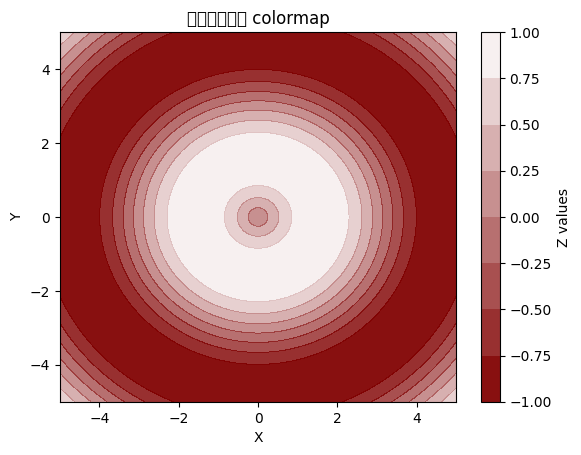

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 创建示例数据
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# 自定义 colormap（颜色和透明度）
def create_alpha_colormap(base_cmap='plasma', alpha=0.7):
    # 获取基础的 colormap
    base = plt.get_cmap(base_cmap)
    # 提取颜色
    base_colors = base(np.arange(base.N))

    alpha_mapped_colors = np.tile(base_colors[np.newaxis,:,:], (base.N, 1, 1))
    alpha_mapped_colors = np.transpose(alpha_mapped_colors, (1,0,2))

    alpha_cmap_all = []
    for i in range(base.N):
        # 修改 alpha 通道
        alpha_mapped_colors[i,:,-1] = np.flip(np.linspace(0, alpha, base.N), axis=0)
    
        # 创建新的 colormap
        alpha_cmap = LinearSegmentedColormap.from_list('alpha_%d'%i, alpha_mapped_colors[i])
        alpha_cmap_all.append(alpha_cmap)
    alpha_cmap_all = np.array(alpha_cmap_all)
    print(alpha_mapped_colors[0])
    print(alpha_mapped_colors[-1])
    return alpha_cmap_all, alpha_mapped_colors

# 创建带透明度的 colormap
alpha_cmap, colors = create_alpha_colormap("jet", alpha=1.)

# 绘制图形并使用自定义的 colormap
plt.contourf(X, Y, Z, cmap=alpha_cmap[-1])

# 添加颜色条
plt.colorbar(label='Z values')

# 设置标签和标题
plt.xlabel('X')
plt.ylabel('Y')
plt.title('自定义透明度 colormap')

# 显示图形
plt.show()


In [3]:
seq_dim = (24,24)

In [4]:

def pbc(i,L=seq_dim[0]):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i
    
from copy import deepcopy
def ising_boltzman_prob_nn(seq, J=1, kBT=1.0):
    shape = seq.shape
    # spins = seq.clone().detach()
    spins = deepcopy(seq)
    spins[np.where(spins==0)]=-1
    B,H,W = shape
    E = np.zeros(B)
    for i in range(H):
        for j in range(W):
            E += -spins[:,i,j]*spins[:,pbc(i-1),j]*J
            E += -spins[:,i,j]*spins[:,pbc(i+1),j]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j-1)]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j+1)]*J

    E /= 2
    prob = np.exp(-E/kBT)
    return E/kBT

def Ising_magnetization(seq):
    data = np.sum(seq.reshape([-1,np.prod(seq_dim)]), axis=-1)
    return data


def logits2seq(logits_t):
    seq_t = []
    for logits in logits_t:
        seq = np.argmax(logits, axis=-1)
        seq[np.where(seq==0)] = -1
        seq_t.append(seq.reshape(-1,*seq_dim))
    return seq_t

def histvar(seq, varfunc, bins):
    var = varfunc(seq)
    hist, bin_edges = np.histogram(var, bins=bins)
    bin_centers = np.array([(bin_edges[i]+bin_edges[i+1])/2. for i in range(len(bin_edges)-1)])
    P = hist/np.sum(hist)
    idxF = np.where(hist>0)
    F = -np.log(P[idxF])
    return hist, bin_centers, P, F, idxF



In [5]:

def run_loading(Tlist):
    magn = np.arange(-np.prod(seq_dim), np.prod(seq_dim)+1, 2)
    bins=np.linspace(magn[0]-1, magn[-1]+1, np.prod(seq_dim)+1+1)

    ### loading MC data and calculating the potential energy and its statistics
    s_time = time.time()
    seq_ref_list = {}
    for idx_jj, jj in enumerate(Tlist):
        print(">>> LOADING REF:: ",jj)
        seq_ref = np.load("../../ising-latt%dx%d-T4.0/latt%dx%d/buffer-S%.2f.npy"%(*seq_dim, *seq_dim, jj)).astype(np.float16).reshape(-1,*seq_dim)
        np.random.shuffle(seq_ref)
        seq_ref = seq_ref[:50000]
        seq_ref[np.where(seq_ref == 0)] = -1
        seq_ref = np.concatenate([seq_ref, -seq_ref], axis=0)
        seq_ref_list[jj] = (seq_ref)
        e_time = time.time()
        print("Time for loading MC data:: ", e_time-s_time)
    return seq_ref_list

In [6]:
Tlist = [4.0, 3.2, 3.0, 2.4, 2.2]
seq_T = run_loading(Tlist)

>>> LOADING REF::  4.0
Time for loading MC data::  3.661257266998291
>>> LOADING REF::  3.2
Time for loading MC data::  6.75744366645813
>>> LOADING REF::  3.0
Time for loading MC data::  12.840364456176758
>>> LOADING REF::  2.4
Time for loading MC data::  15.978502750396729
>>> LOADING REF::  2.2
Time for loading MC data::  19.052967309951782


In [7]:
magn_T = {}
pote_T = {}
for T in Tlist:
    magn_T[T] = Ising_magnetization(seq_T[T])
    pote_T[T] = ising_boltzman_prob_nn(seq_T[T])

/tmp/ipykernel_358162/340915759.py:26: RuntimeWarning: overflow encountered in exp
  prob = np.exp(-E/kBT)


In [8]:

X_latt12 = {}
Y_latt12 = {}
H_latt12 = {}
for T in Tlist:
    H_latt12[T], xedges, yedges = np.histogram2d(magn_T[T], pote_T[T], range=[[-np.prod(seq_dim), np.prod(seq_dim)], [-1100, 0]], bins=40)
    X_latt12[T], Y_latt12[T] = np.meshgrid((xedges[1:]+xedges[:-1])/2./np.prod(seq_dim),(yedges[1:]+yedges[:-1])/2./np.prod(seq_dim))


In [9]:
FES_T = {}
for T in Tlist:
    H_masked = np.ma.masked_where(H_latt12[T] == 0, H_latt12[T])
    FES_T[T] = -T*np.log(H_masked.T)
    FES_T[T] -= FES_T[T].min()

/tmp/ipykernel_358162/65352073.py:4: RuntimeWarning: divide by zero encountered in log
  FES_T[T] = -T*np.log(H_masked.T)


In [10]:

font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 12
}  
def setfigform_simple(xlabel, ylabel=None, xlimit = (None,None), ylimit = (None, None), xticks=None):
    # plt.legend(fontsize = 16, frameon=False),
    plt.xlabel(xlabel, fontdict = font)
    plt.ylabel(ylabel, fontdict = font)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    if xticks is None:
        plt.xticks(fontsize = font['size'], fontname = "serif")
    else:
        plt.xticks(xticks, fontsize = font['size'], fontname = "serif")
    plt.yticks(fontsize = font['size'], fontname = "serif")
    plt.tick_params(direction="in")

In [11]:

coloridx_list = [int((T-2.0000001)/(3.2-2)*256) for T in Tlist]
print(coloridx_list)

[426, 255, 213, 85, 42]


In [12]:
for T in Tlist:
    FES_T[T][np.where(FES_T[T]>4)] = 4

In [13]:
import json
with open('/nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/Pred_dict.json', 'r', encoding='utf-8') as json_file:
    Pred_dict_ = json.load(json_file)

In [14]:

def ReadReferenceF(filename):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break

        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        jj = float(line.split()[-1].replace("kBT=",""))

        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])

        Reference_dict[jj]=np.stack([bin_centers, F])
    ofile_prob_E.close()
    return Reference_dict

def ReadReferenceF_potE(filename, readerror=False):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break

        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        jj = float(line.split()[-1].replace("kBT=",""))

        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])
        if readerror:
            line = ofile_prob_E.readline()
            if not "ERROR" in line: 
                raise Exception("ERROR:: ERROR data not found in ", filename)
            line = ofile_prob_E.readline()
            errF = np.array([float(x) for x in line.split()])
        if readerror:
            Reference_dict[jj]=np.stack([bin_centers, F, errF])
        else:
            Reference_dict[jj]=np.stack([bin_centers, F])
    ofile_prob_E.close()
    return Reference_dict


In [15]:
L=24
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(L,L,L,L)
Reference_dict = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))
Expectation_Reference_dict = {}
Expectation_Reference_dict["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [17]:
print(Pred_dict_.keys())
print(Pred_dict_["T2.2L24"]["Predictions"].keys())
print(Pred_dict_["T2.2L24"]["Predictions"]["seq_path"])
# print(Pred_dict_["T2.2L24"]["Predictions"]["Flow"])
print(Pred_dict_["T2.2L24"]["guidance_coeff"])
# print(Pred_dict_["T2.2L18"]["guidance_coeff"])
# print(Pred_dict_["T2.2L12"]["guidance_coeff"])
print(Pred_dict_["T2.2L6"]["guidance_coeff"])


dict_keys(['T3.2L6', 'T1.2L6', 'T2.8L6', 'T2.2L6', 'T2.4L6', 'T3.2L12', 'T2.0L12', 'T1.2L24', 'T3.2L24', 'T2.0L24', 'T1.0L24', 'T2.2L24', 'T3.0L24', 'T1.4L24'])
dict_keys(['Lattice_dim', 'Flow', 'Flow-PotE', 'FlowProbs-PotE', 'FlowExpectations-PotE', 'seq_path'])
val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0/seq_val.npy
0.18
0.24


In [18]:
import os
import glob
def loadmodelprediction(_dirname, epoch=None, num_batches=1, file_header="logits"):
    dirname = _dirname
    f_logits_t = glob.glob(os.path.join(dirname, file_header+"_val_inttime*"))
    print(">>> Reading model predictions from: ", dirname)

    logits_t = np.array([np.load(f).astype(np.float16) for f in f_logits_t])
    diffusion_t = np.array([float(x.replace(os.path.join(dirname, file_header+"_val_inttime"), "").replace(".npy",""))-1 for x in f_logits_t])
    idx_order = np.argsort(diffusion_t)
    logits_t = logits_t[idx_order]
    diffusion_t = diffusion_t[idx_order]
    return logits_t, diffusion_t

def logits2seq(logits_t):
    seq_t = []
    for logits in logits_t:
        seq = np.argmax(logits, axis=-1)
        seq[np.where(seq==0)] = -1
        seq_t.append(seq.reshape(-1,*seq_dim))
    return seq_t

def Ising_magnetization(seq):
    data = np.sum(seq.reshape([-1,np.prod(seq_dim)]), axis=-1)
    return data

def pbc(i,L=seq_dim[0]):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i
from copy import deepcopy
def ising_boltzman_prob_nn(seq, J=1, kBT=1.0):
    shape = seq.shape
    # spins = seq.clone().detach()
    spins = deepcopy(seq)
    spins[np.where(spins==0)]=-1
    B,H,W = shape
    E = np.zeros(B)
    for i in range(H):
        for j in range(W):
            E += -spins[:,i,j]*spins[:,pbc(i-1),j]*J
            E += -spins[:,i,j]*spins[:,pbc(i+1),j]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j-1)]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j+1)]*J

    E /= 2
    # prob = np.exp(-E/kBT)
    return E/kBT


In [19]:
pred_seq_path = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0"
pred_logits, _ = loadmodelprediction(pred_seq_path)

>>> Reading model predictions from:  /nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.18/g0


In [20]:
pred_seq_ = logits2seq(pred_logits)
pred_magn = [Ising_magnetization(s) for s in pred_seq_]
pred_pote = [ising_boltzman_prob_nn(s) for s in pred_seq_]
pred_seq_T = {}
pred_seq_T[2.2] = pred_seq_
pred_magn_T = {}
pred_magn_T[2.2] = pred_magn
pred_pote_T = {}
pred_pote_T[2.2] = pred_pote

In [21]:

pred_seq_path = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0"
pred_logits, _ = loadmodelprediction(pred_seq_path)
pred_seq_T[3.2] = logits2seq(pred_logits)

pred_magn_T[3.2] = [Ising_magnetization(s) for s in pred_seq_T[3.2]]
pred_pote_T[3.2] = [ising_boltzman_prob_nn(s) for s in pred_seq_T[3.2]]

>>> Reading model predictions from:  /nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.0/g0


In [22]:
pred_seq_path = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.13/g0"
pred_logits, _ = loadmodelprediction(pred_seq_path)
pred_seq_T[2.4] = logits2seq(pred_logits)

>>> Reading model predictions from:  /nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.13/g0


In [23]:

pred_magn_T[2.4] = [Ising_magnetization(s) for s in pred_seq_T[2.4]]
pred_pote_T[2.4] = [ising_boltzman_prob_nn(s) for s in pred_seq_T[2.4]]

In [24]:
pred_seq_path = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.02/g0"
pred_logits, _ = loadmodelprediction(pred_seq_path)
pred_seq_T[3.] = logits2seq(pred_logits)
pred_magn_T[3.] = [Ising_magnetization(s) for s in pred_seq_T[3.]]
pred_pote_T[3.] = [ising_boltzman_prob_nn(s) for s in pred_seq_T[3.]]

>>> Reading model predictions from:  /nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T3.2/kernel3x3_timeembed_symmetrized/clsfreeG/eloss_guidanceEM/val_baseline_latt24x24/epoch209_IntStep640_AMax10_clsT2.8L24c_tilt0.25_dfreq8_uncondm5/tilt0.02/g0


In [25]:
pred_seq_T_custom = {}
pred_seq_path = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T2.4/kernel3x3_timeembed_symmetrized/finetune3/val_baseline_latt24x24/epoch769_IntStep80_AMax10/"
pred_logits, _ = loadmodelprediction(pred_seq_path)
pred_seq_T_custom[2.4] = logits2seq(pred_logits)

>>> Reading model predictions from:  /nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T2.4/kernel3x3_timeembed_symmetrized/finetune3/val_baseline_latt24x24/epoch769_IntStep80_AMax10/


In [26]:
pred_magn_T_custom = {}
pred_pote_T_custom = {}
pred_magn_T_custom[2.4] = [Ising_magnetization(s) for s in pred_seq_T_custom[2.4]]
pred_pote_T_custom[2.4] = [ising_boltzman_prob_nn(s) for s in pred_seq_T_custom[2.4]]

In [27]:

def ReadPredF(filename):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break
        jj = float(line.split()[1].replace("alpha-1=","").replace(";",""))
        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        line = ofile_prob_E.readline()
        errF = np.array([float(x) for x in line.split()])

        Reference_dict[jj]=np.stack([bin_centers, F, errF])
    ofile_prob_E.close()
    return Reference_dict

Pred_dict_["T2.4L24"] = {}
Pred_dict_["T2.4L24"]["Predictions"] = {}
Pred_dict_["T2.4L24"]["Predictions"]["Flow-PotE"]=ReadPredF("/nfs/scistore14/chenggrp/ptuo/NeuralRG/alchemicalFES/logs-dir-ising/latt6x6T2.4/kernel3x3_timeembed_symmetrized/finetune3/val_baseline_latt24x24/epoch769_IntStep80_AMax10/FES-E.dat")


In [ ]:
plt.figure(figsize=(5,5))

for idx_T in [1,3,4]:
    T = Tlist[idx_T]
    plt.plot(Reference_dict_potE[T][0]/L**2, Reference_dict_potE[T][1], c=colors[coloridx_list[idx_T]][104])

Diffusion_Times = list(Pred_dict_["T2.2L24"]["Predictions"]["Flow-PotE"].keys())
plt.errorbar(np.array(Pred_dict_["T2.2L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[-1]][0])/L**2, Pred_dict_["T2.2L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[-1]][1], yerr=Pred_dict_["T2.2L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[-1]][2], linestyle='none', c=colors[coloridx_list[4]][0], marker="D", ms=3, label="Flow matching, $k_BT=2.2$")

Diffusion_Times = list(Pred_dict_["T2.4L24"]["Predictions"]["Flow-PotE"].keys())
plt.errorbar(np.array(Pred_dict_["T2.4L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[46]][0])/L**2, Pred_dict_["T2.4L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[46]][1], yerr=Pred_dict_["T2.4L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[46]][2], linestyle='none', c=colors[coloridx_list[3]][0], marker="D", ms=3, label="Flow matching, $k_BT=2.4$")

Diffusion_Times = list(Pred_dict_["T3.2L24"]["Predictions"]["Flow-PotE"].keys())
plt.errorbar(np.array(Pred_dict_["T3.2L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[-1]][0])/L**2, Pred_dict_["T3.2L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[-1]][1], yerr=Pred_dict_["T3.2L24"]["Predictions"]["Flow-PotE"][Diffusion_Times[-1]][2], linestyle='none', c=colors[coloridx_list[1]][0], marker="D", ms=3, label="Flow matching, $k_BT=3.2$")
plt.legend(fontsize = 12)
setfigform_simple(r"$U/N$", r"$F$", ylimit=(2,6))

In [ ]:
plt.figure(figsize=(5,5))
Diffusion_Times = list(Pred_dict_["T2.2L24"]["Predictions"]["Flow-PotE"].keys())
for idx_T in [1,4]:
    T = Tlist[idx_T]
    plt.plot(Reference_dict[T][0]/L**2, Reference_dict[T][1], c=colors[coloridx_list[idx_T]][104])

plt.errorbar(np.array(Pred_dict_["T2.2L24"]["Predictions"]["Flow"][Diffusion_Times[-1]][0])/L**2, Pred_dict_["T2.2L24"]["Predictions"]["Flow"][Diffusion_Times[-1]][1], yerr=Pred_dict_["T2.2L24"]["Predictions"]["Flow"][Diffusion_Times[-1]][2], linestyle='none', c=colors[coloridx_list[4]][0], marker="D", ms=3, label="Flow matching, $k_BT=2.2$")
plt.errorbar(np.array(Pred_dict_["T3.2L24"]["Predictions"]["Flow"][Diffusion_Times[-1]][0])/L**2, Pred_dict_["T3.2L24"]["Predictions"]["Flow"][Diffusion_Times[-1]][1], yerr=Pred_dict_["T3.2L24"]["Predictions"]["Flow"][Diffusion_Times[-1]][2], linestyle='none', c=colors[coloridx_list[1]][0], marker="D", ms=3, label="Flow matching, $k_BT=3.2$")
plt.legend(fontsize = 12)
setfigform_simple(r"$m/N$", r"$F$", ylimit=(3,6))

/tmp/ipykernel_358162/218344709.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contourf(X_latt12[Tlist[idx_T]], Y_latt12[Tlist[idx_T]], FES_T[Tlist[idx_T]], levels=80, cmap=alpha_cmap[coloridx_list[idx_T]], vmax=4, label="$k_BT$=%.1f"%(Tlist[idx_T]))


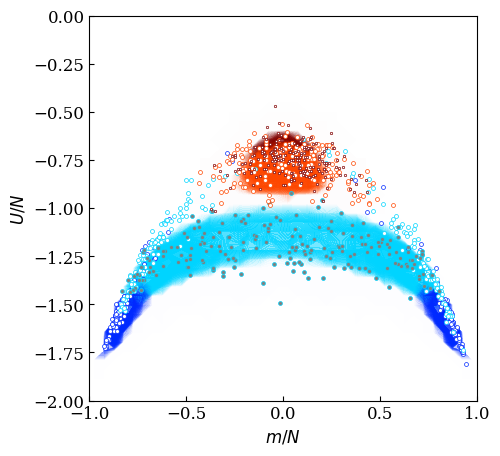

In [28]:
from matplotlib import font_manager

plt.figure(figsize=(5,5))
for idx_T in range(1, len(Tlist)):
    contour = plt.contourf(X_latt12[Tlist[idx_T]], Y_latt12[Tlist[idx_T]], FES_T[Tlist[idx_T]], levels=80, cmap=alpha_cmap[coloridx_list[idx_T]], vmax=4, label="$k_BT$=%.1f"%(Tlist[idx_T]))
    # cbar = plt.colorbar(contour)
    # # contour.set_clim(0, 10) 
    # cbar.set_ticks([0, 1, 2, 3, 4])
    # cbar.set_label("FES", fontsize=12, fontname = "serif")
    # font = font_manager.FontProperties(family='serif', size=12)  # 自定义字体属性
    # # 使用 FontProperties 设置 colorbar 刻度标签的字体
    # for label in cbar.ax.get_yticklabels():
    #     label.set_fontproperties(font)
# plt.legend(fontsize = 16)
plt.scatter(pred_magn_T[2.2][-1][:200]/24**2, pred_pote_T[2.2][-1][:200]/24**2, edgecolors=colors[coloridx_list[4]][0], c="w", s=8, linewidths=0.5)
plt.scatter(pred_magn_T[2.4][-1][:200]/24**2, pred_pote_T[2.4][-1][:200]/24**2, edgecolors=colors[coloridx_list[3]][0], c="w", s=8, linewidths=0.5)
plt.scatter(pred_magn_T_custom[2.4][46][:200]/24**2, pred_pote_T_custom[2.4][46][:200]/24**2, edgecolors=colors[coloridx_list[3]][0], c="grey", s=8, linewidths=0.5)
plt.scatter(pred_magn_T[3.][-1][:200]/24**2, pred_pote_T[3.][-1][:200]/24**2, edgecolors=colors[coloridx_list[2]][0], c="w", s=8, linewidths=0.5)
plt.scatter(pred_magn_T[3.2][-1][:200]/24**2, pred_pote_T[3.2][-1][:200]/24**2, edgecolors=colors[coloridx_list[1]][0], c="w", s=3, linewidths=0.5)
setfigform_simple(r"$m/N$", r"$U/N$", xticks=[-1.0, -0.5, 0, 0.5, 1.], ylimit=(-2,0))
# plt.savefig("FES-latt12")